# GAN for Pistachio Image Generation

## Library

In [1]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from tensorflow.keras.utils import img_to_array
from datasets import load_dataset
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
import time
from tensorflow.keras import layers, Model, Sequential

c:\Users\Kelvin Jonathan\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- Load all the required libraries

## Load Data

In [2]:
def sorted_alphanumeric(data):
  convert = lambda text: int(text) if text.isdigit() else text.lower()
  alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
  return sorted(data,key = alphanum_key)

SIZE = 100
_img = []
path = 'B_23'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
  img = cv2.imread(path + '/'+i,1)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (SIZE, SIZE))
  img = (img - 127.5) / 127.5
  imh = img.astype(float)
  _img.append(img_to_array(img))

100%|██████████| 1074/1074 [00:08<00:00, 121.46it/s]


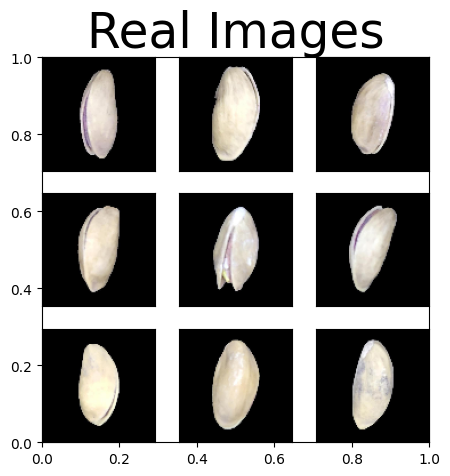

In [3]:
def plot_images(sqr = 5):
  plt.figure(figsize = (5,5))
  plt.title("Real Images",fontsize = 35)
  for i in range(sqr * sqr):
    plt.subplot(sqr,sqr,i+1)
    plt.imshow(_img[i]*0.5 + 0.5 )
    plt.xticks([])
    plt.yticks([])

plot_images(3)

In [4]:
batch_size= 2
dataset=tf.data.Dataset.from_tensor_slices(np.array(_img)).batch(batch_size)

- A batch size of **2** was used during training to prevent **Out of Memory (OOM)** errors, which can occur when the model and dataset are too large for the available GPU or system memory

## Baseline Model

In [5]:
latent_dim=100
def Generator():
  model= tf.keras.Sequential(name="Generator")

  model.add(tf.keras.layers.Dense(30 * 30 * 64, input_shape=(latent_dim,)))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.Reshape((30, 30, 64)))

  model.add(tf.keras.layers.UpSampling2D(size=(2, 2)))
  model.add(tf.keras.layers.Conv2D(16, kernel_size=3, strides=1, padding='valid', activation='relu'))

  model.add(tf.keras.layers.UpSampling2D(size=(2, 2)))
  model.add(tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='valid', activation='relu'))

  model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='valid', activation='relu'))

  model.add(tf.keras.layers.Conv2D(3, kernel_size=3, strides=1, padding='valid', activation='tanh'))

  model.add(tf.keras.layers.Cropping2D(cropping=((5, 5), (5, 5))))

  return model

generator = Generator()
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 57600)             5817600   
                                                                 
 activation (Activation)     (None, 57600)             0         
                                                                 
 reshape (Reshape)           (None, 30, 30, 64)        0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 60, 60, 64)       0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 58, 58, 16)        9232      
                                                                 
 up_sampling2d_1 (UpSampling  (None, 116, 116, 16)     0         
 2D)                                                     

In [6]:
def Discriminator(image_shape=(100, 100, 3)):
  model= Sequential(name="Discriminator")

  model.add(layers.Conv2D(16, (3, 3), strides=1, padding='valid', activation='relu', input_shape= image_shape))
  
  model.add(layers.Conv2D(32, (3, 3), strides=1, padding='valid',  activation='relu'))
  
  model.add(layers.Conv2D(64, (3, 3), strides=1, padding='valid',  activation='relu'))

  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))

  return model

discriminator= Discriminator()
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 98, 98, 16)        448       
                                                                 
 conv2d_5 (Conv2D)           (None, 96, 96, 32)        4640      
                                                                 
 conv2d_6 (Conv2D)           (None, 94, 94, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 565504)            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 565505    
                                                                 
Total params: 589,089
Trainable params: 589,089
Non-trainable params: 0
_________________________________________________________________


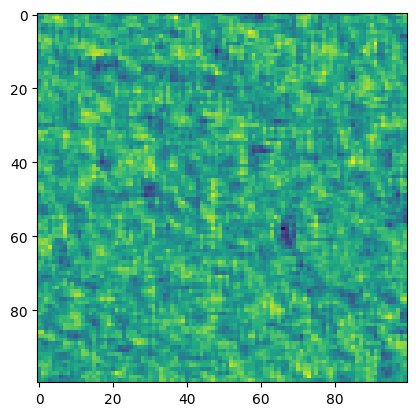

In [7]:
noise= np.random.normal(-1,1,(1,100))
img= generator(noise)
plt.imshow(img[0,:,:,0])
plt.show()

In [8]:
generator_optimizer= tf.keras.optimizers.Adam(
  learning_rate=1e-4,
  beta_1=0.5,  
  beta_2=0.999
)

discriminator_optimizer= tf.keras.optimizers.Adam(
  learning_rate=1e-4,
  beta_1=0.5,  
  beta_2=0.999
)
cross_entropy= tf.keras.losses.BinaryCrossentropy(from_logits = True)

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)
def discriminator_loss(fake_output, real_output):
  fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
  real_loss = cross_entropy(tf.ones_like(real_output),real_output)
  return fake_loss + real_loss

### Train Baseline Model

In [9]:
@tf.function
def train_step(images):
  noise = tf.random.normal([batch_size, latent_dim])
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)
    
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(fake_output, real_output)
  
  gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  
  generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
  
  return gen_loss, disc_loss

- The `train_step` function performs **one training step** for a Generative Adversarial Network (GAN).  
- Inside the function:
  - A batch of random noise is generated as input for the **generator**.
  - The generator produces fake images, which are evaluated by the **discriminator**.
  - Two loss values are calculated:
    - `gen_loss`: how well the generator fools the discriminator.
    - `disc_loss`: how well the discriminator distinguishes between real and fake images.
  - Gradients are computed and **applied** to update the trainable variables of both the generator and discriminator.
- The `@tf.function` decorator compiles the function into a TensorFlow graph for faster and more efficient execution.

c:\Users\Kelvin Jonathan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/100, Gen Loss: 2.3792, Disc Loss: 1.1810, Time: 12.75s
Epoch 2/100, Gen Loss: 1.3043, Disc Loss: 0.9648, Time: 9.16s
Epoch 3/100, Gen Loss: 1.1723, Disc Loss: 1.0815, Time: 9.09s
Epoch 4/100, Gen Loss: 1.2258, Disc Loss: 1.0262, Time: 8.81s
Epoch 5/100, Gen Loss: 1.3594, Disc Loss: 0.9035, Time: 8.51s
Epoch 6/100, Gen Loss: 1.3227, Disc Loss: 0.9079, Time: 8.65s
Epoch 7/100, Gen Loss: 1.2215, Disc Loss: 1.0119, Time: 9.00s
Epoch 8/100, Gen Loss: 1.2266, Disc Loss: 1.0132, Time: 8.99s
Epoch 9/100, Gen Loss: 1.2360, Disc Loss: 0.9991, Time: 9.20s
Epoch 10/100, Gen Loss: 1.2264, Disc Loss: 0.9861, Time: 9.01s


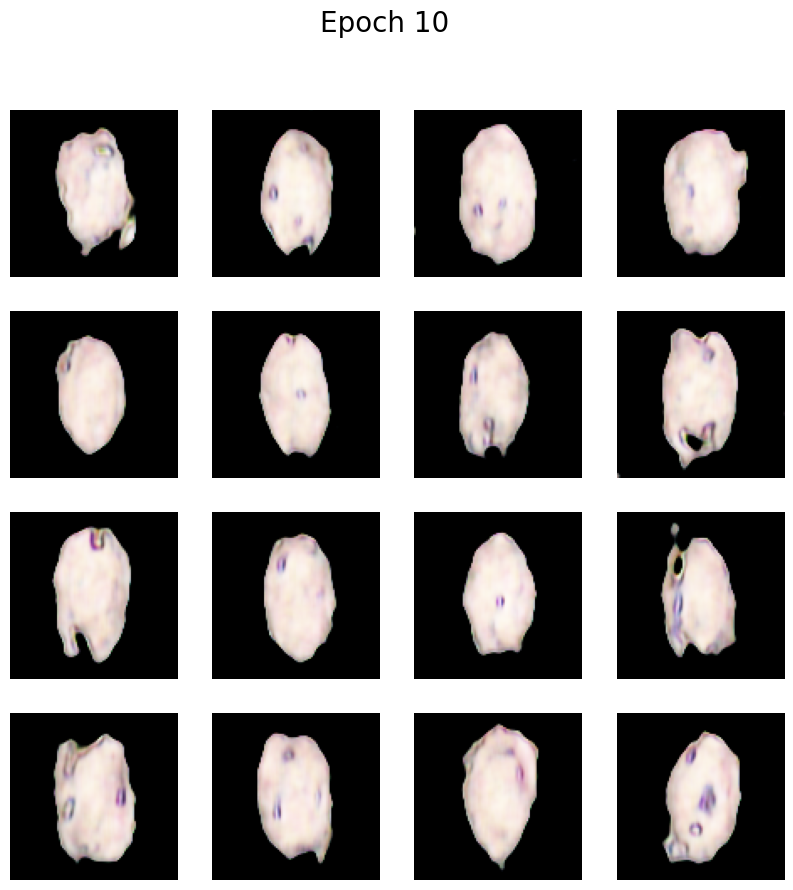

Epoch 11/100, Gen Loss: 1.3167, Disc Loss: 0.9282, Time: 9.02s
Epoch 12/100, Gen Loss: 1.3521, Disc Loss: 0.9054, Time: 9.29s
Epoch 13/100, Gen Loss: 1.3646, Disc Loss: 0.8958, Time: 9.50s
Epoch 14/100, Gen Loss: 1.3704, Disc Loss: 0.8645, Time: 9.59s
Epoch 15/100, Gen Loss: 1.4328, Disc Loss: 0.8452, Time: 9.63s
Epoch 16/100, Gen Loss: 1.5091, Disc Loss: 0.8118, Time: 44.46s
Epoch 17/100, Gen Loss: 1.5567, Disc Loss: 0.7794, Time: 10.00s
Epoch 18/100, Gen Loss: 1.6079, Disc Loss: 0.7589, Time: 10.05s
Epoch 19/100, Gen Loss: 1.6485, Disc Loss: 0.7302, Time: 10.15s
Epoch 20/100, Gen Loss: 1.6725, Disc Loss: 0.7238, Time: 10.12s


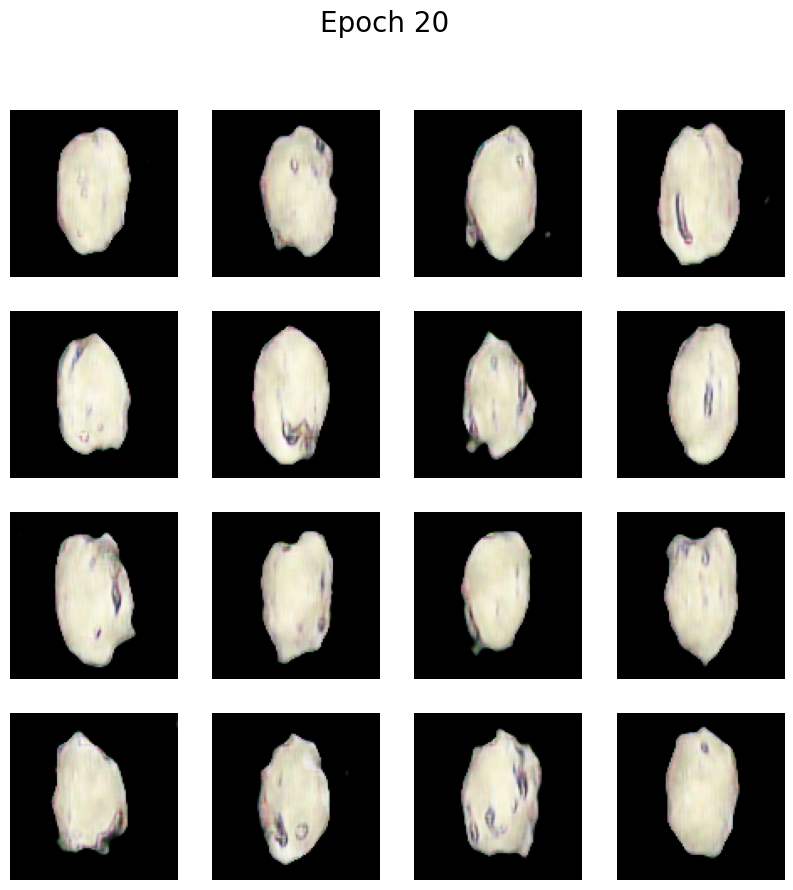

Epoch 21/100, Gen Loss: 1.6453, Disc Loss: 0.7332, Time: 10.20s
Epoch 22/100, Gen Loss: 1.7501, Disc Loss: 0.7101, Time: 9.80s
Epoch 23/100, Gen Loss: 1.7707, Disc Loss: 0.7037, Time: 10.22s
Epoch 24/100, Gen Loss: 1.8288, Disc Loss: 0.6757, Time: 10.27s
Epoch 25/100, Gen Loss: 1.8024, Disc Loss: 0.6808, Time: 10.13s
Epoch 26/100, Gen Loss: 1.8186, Disc Loss: 0.6871, Time: 10.12s
Epoch 27/100, Gen Loss: 1.8918, Disc Loss: 0.6644, Time: 10.11s
Epoch 28/100, Gen Loss: 1.9497, Disc Loss: 0.6377, Time: 10.11s
Epoch 29/100, Gen Loss: 2.0725, Disc Loss: 0.5982, Time: 10.10s
Epoch 30/100, Gen Loss: 2.0938, Disc Loss: 0.5927, Time: 10.11s


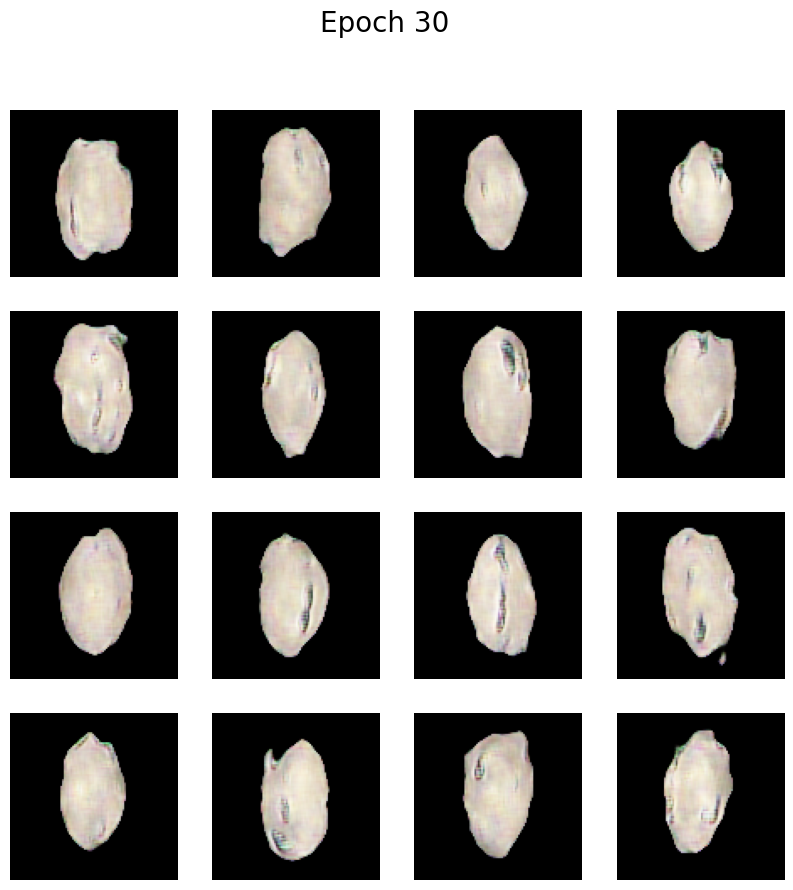

Epoch 31/100, Gen Loss: 2.2064, Disc Loss: 0.5947, Time: 10.12s
Epoch 32/100, Gen Loss: 2.1665, Disc Loss: 0.5653, Time: 10.11s
Epoch 33/100, Gen Loss: 2.1931, Disc Loss: 0.5412, Time: 10.10s
Epoch 34/100, Gen Loss: 2.1456, Disc Loss: 0.5865, Time: 10.06s
Epoch 35/100, Gen Loss: 2.4589, Disc Loss: 0.5029, Time: 10.08s
Epoch 36/100, Gen Loss: 2.3462, Disc Loss: 0.5095, Time: 10.11s
Epoch 37/100, Gen Loss: 2.3518, Disc Loss: 0.5403, Time: 10.11s
Epoch 38/100, Gen Loss: 2.3780, Disc Loss: 0.5190, Time: 10.12s
Epoch 39/100, Gen Loss: 2.4952, Disc Loss: 0.4831, Time: 10.18s
Epoch 40/100, Gen Loss: 2.5890, Disc Loss: 0.4558, Time: 10.22s


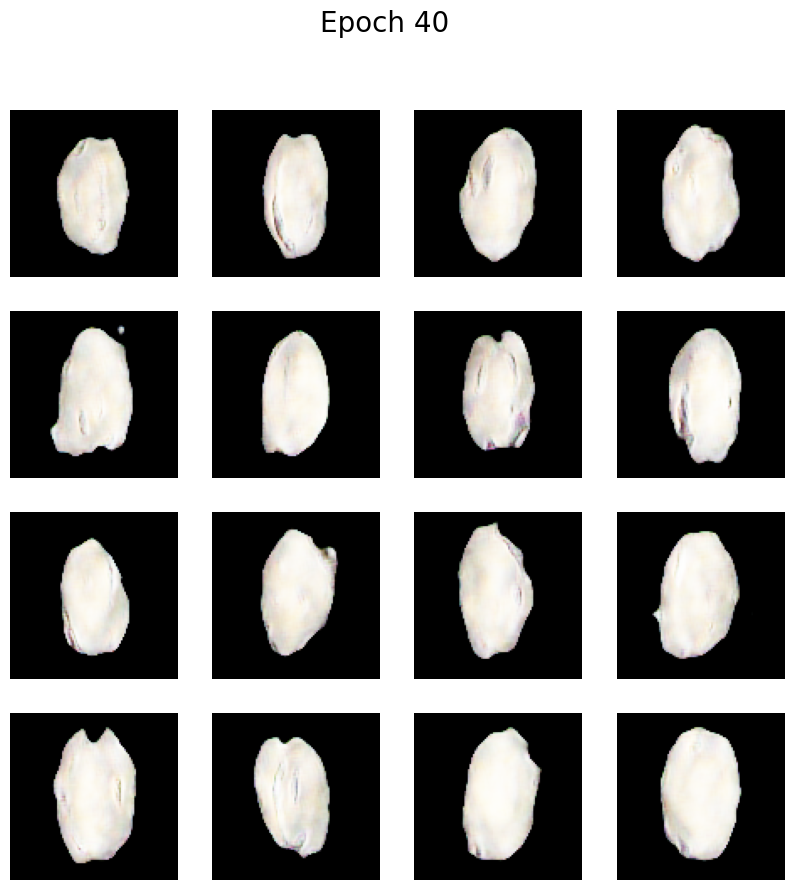

Epoch 41/100, Gen Loss: 2.7241, Disc Loss: 0.4460, Time: 10.31s
Epoch 42/100, Gen Loss: 2.6881, Disc Loss: 0.4721, Time: 10.06s
Epoch 43/100, Gen Loss: 2.7850, Disc Loss: 0.4285, Time: 10.20s
Epoch 44/100, Gen Loss: 2.8041, Disc Loss: 0.4319, Time: 10.25s
Epoch 45/100, Gen Loss: 2.8542, Disc Loss: 0.4492, Time: 10.24s
Epoch 46/100, Gen Loss: 2.9843, Disc Loss: 0.4040, Time: 10.22s
Epoch 47/100, Gen Loss: 2.9474, Disc Loss: 0.3933, Time: 10.32s
Epoch 48/100, Gen Loss: 2.9796, Disc Loss: 0.3662, Time: 10.31s
Epoch 49/100, Gen Loss: 2.9824, Disc Loss: 0.3919, Time: 10.10s
Epoch 50/100, Gen Loss: 3.1407, Disc Loss: 0.3774, Time: 10.24s


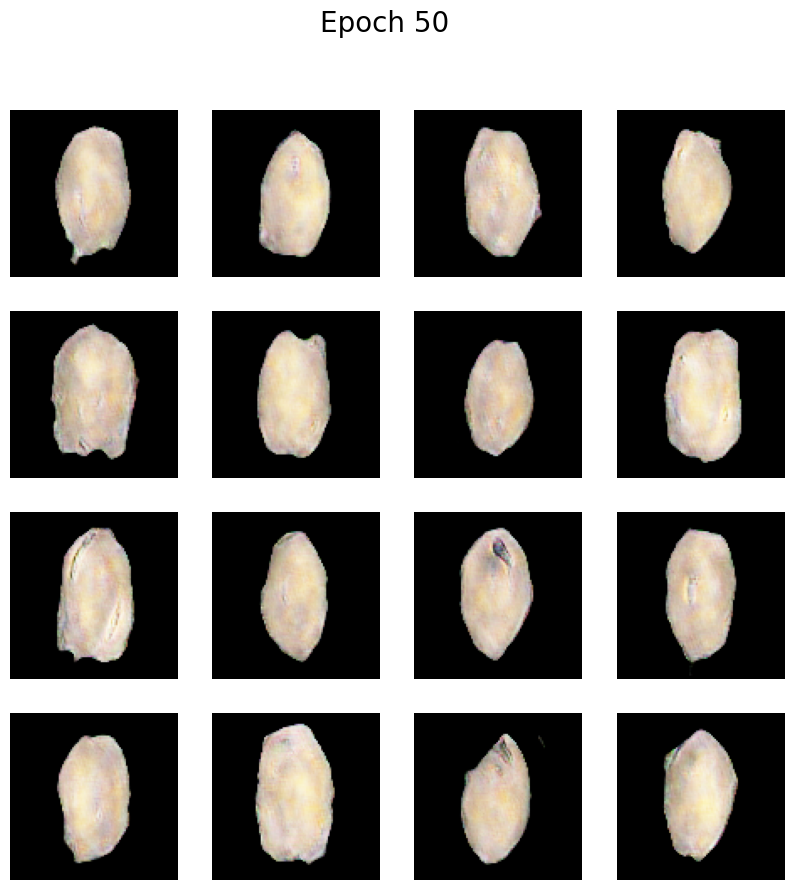

Epoch 51/100, Gen Loss: 3.3487, Disc Loss: 0.3261, Time: 10.28s
Epoch 52/100, Gen Loss: 3.2237, Disc Loss: 0.3615, Time: 10.22s
Epoch 53/100, Gen Loss: 3.1552, Disc Loss: 0.3672, Time: 9.87s
Epoch 54/100, Gen Loss: 3.2864, Disc Loss: 0.3439, Time: 10.45s
Epoch 55/100, Gen Loss: 3.4465, Disc Loss: 0.3156, Time: 10.11s
Epoch 56/100, Gen Loss: 3.2552, Disc Loss: 0.3579, Time: 9.99s
Epoch 57/100, Gen Loss: 3.4377, Disc Loss: 0.3323, Time: 10.33s
Epoch 58/100, Gen Loss: 3.4361, Disc Loss: 0.3003, Time: 10.46s
Epoch 59/100, Gen Loss: 3.3101, Disc Loss: 0.3446, Time: 10.45s
Epoch 60/100, Gen Loss: 3.7026, Disc Loss: 0.2806, Time: 10.21s


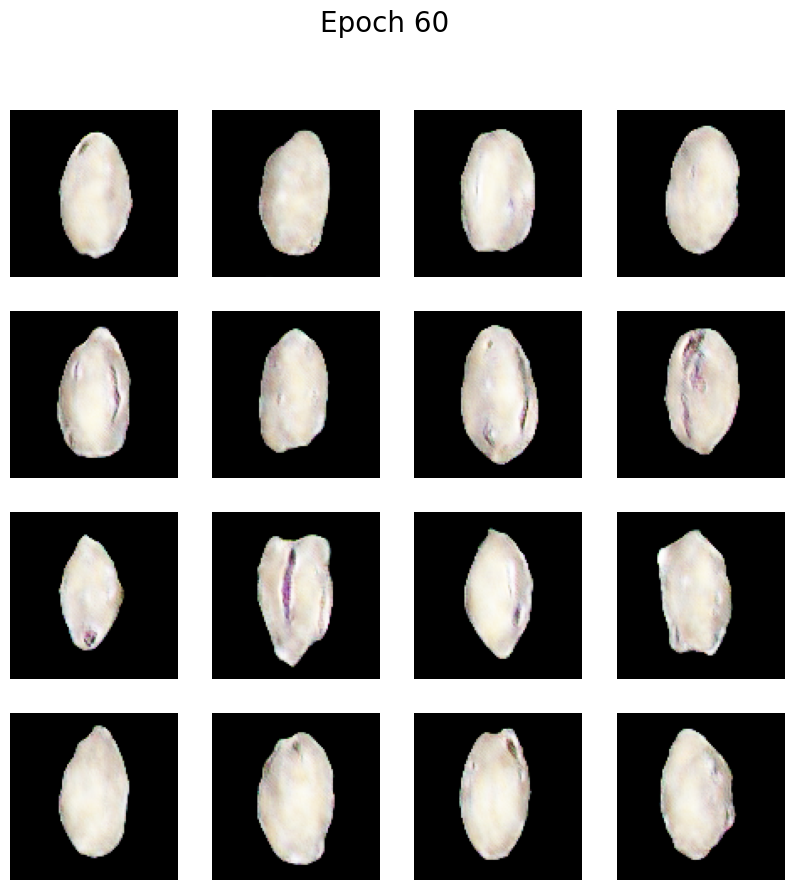

Epoch 61/100, Gen Loss: 3.6927, Disc Loss: 0.2845, Time: 10.25s
Epoch 62/100, Gen Loss: 3.8068, Disc Loss: 0.2652, Time: 10.43s
Epoch 63/100, Gen Loss: 3.7735, Disc Loss: 0.2569, Time: 10.32s
Epoch 64/100, Gen Loss: 3.6667, Disc Loss: 0.2993, Time: 9.10s
Epoch 65/100, Gen Loss: 3.8311, Disc Loss: 0.2848, Time: 9.53s
Epoch 66/100, Gen Loss: 4.1355, Disc Loss: 0.2163, Time: 9.64s
Epoch 67/100, Gen Loss: 3.8442, Disc Loss: 0.2720, Time: 9.71s
Epoch 68/100, Gen Loss: 3.9876, Disc Loss: 0.2410, Time: 9.64s
Epoch 69/100, Gen Loss: 4.0594, Disc Loss: 0.2487, Time: 9.92s
Epoch 70/100, Gen Loss: 3.9732, Disc Loss: 0.2610, Time: 9.71s


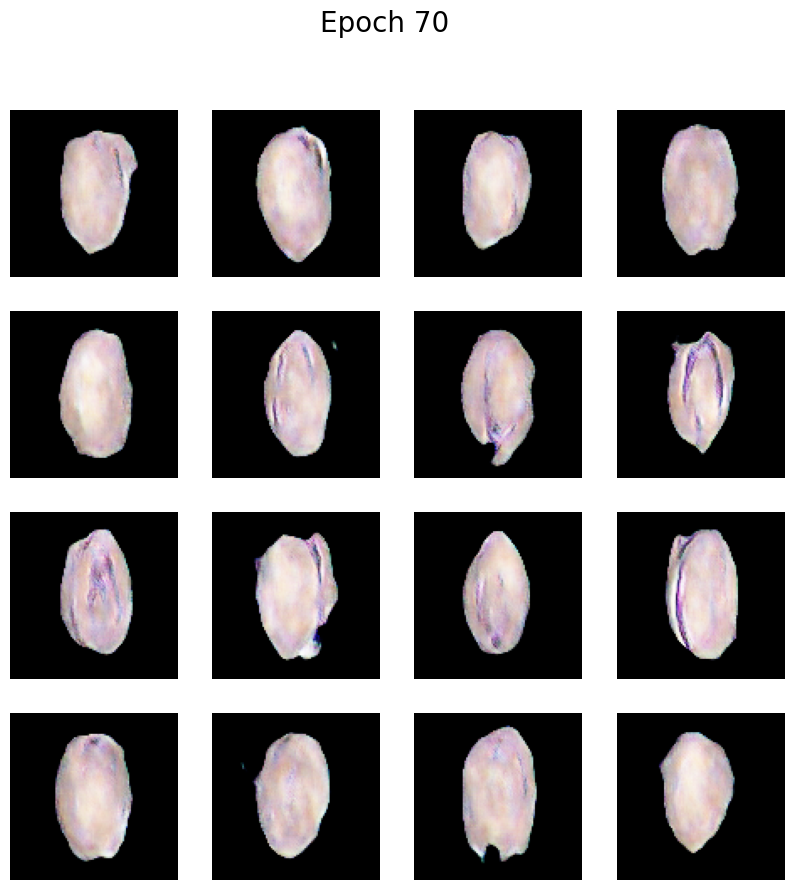

Epoch 71/100, Gen Loss: 4.2778, Disc Loss: 0.2313, Time: 9.76s
Epoch 72/100, Gen Loss: 4.0944, Disc Loss: 0.2018, Time: 93.75s
Epoch 73/100, Gen Loss: 4.3540, Disc Loss: 0.2326, Time: 62.83s
Epoch 74/100, Gen Loss: 4.2769, Disc Loss: 0.2245, Time: 9.66s
Epoch 75/100, Gen Loss: 4.1369, Disc Loss: 0.2370, Time: 9.71s
Epoch 76/100, Gen Loss: 4.2775, Disc Loss: 0.2182, Time: 9.80s
Epoch 77/100, Gen Loss: 4.2300, Disc Loss: 0.2333, Time: 10.06s
Epoch 78/100, Gen Loss: 4.4756, Disc Loss: 0.2213, Time: 10.02s
Epoch 79/100, Gen Loss: 4.4357, Disc Loss: 0.2173, Time: 10.17s
Epoch 80/100, Gen Loss: 4.3214, Disc Loss: 0.2404, Time: 10.09s


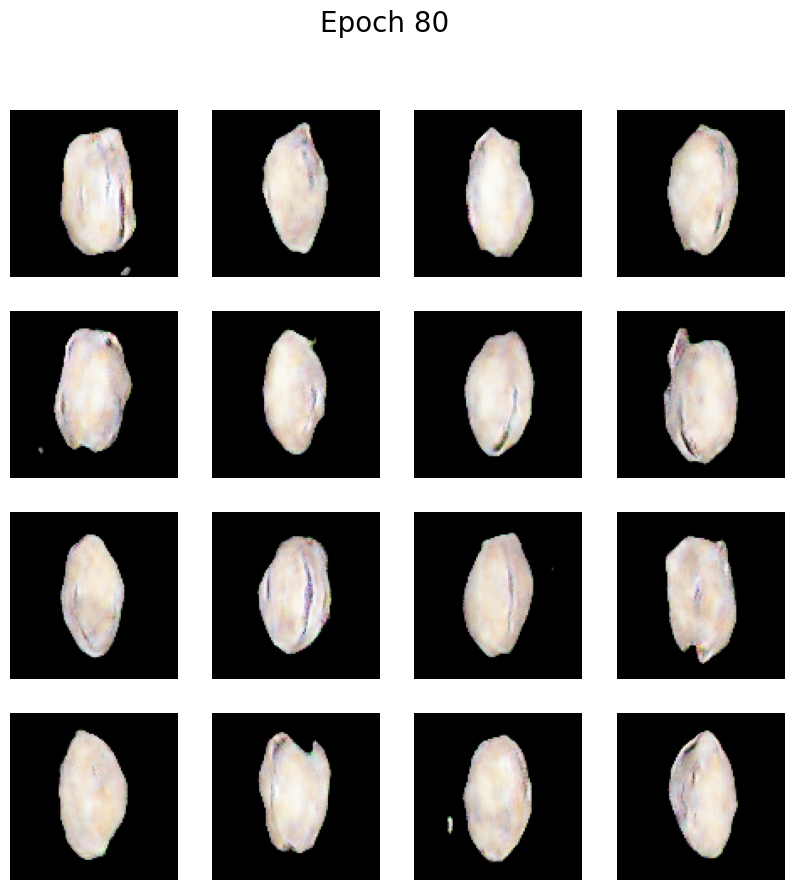

Epoch 81/100, Gen Loss: 4.5649, Disc Loss: 0.1887, Time: 10.00s
Epoch 82/100, Gen Loss: 4.4730, Disc Loss: 0.2012, Time: 10.00s
Epoch 83/100, Gen Loss: 4.4651, Disc Loss: 0.2107, Time: 10.65s
Epoch 84/100, Gen Loss: 4.5841, Disc Loss: 0.1931, Time: 10.24s
Epoch 85/100, Gen Loss: 4.5854, Disc Loss: 0.2143, Time: 9.84s
Epoch 86/100, Gen Loss: 4.6511, Disc Loss: 0.1934, Time: 9.74s
Epoch 87/100, Gen Loss: 4.6176, Disc Loss: 0.2094, Time: 10.12s
Epoch 88/100, Gen Loss: 5.0118, Disc Loss: 0.1557, Time: 10.37s
Epoch 89/100, Gen Loss: 4.7805, Disc Loss: 0.1714, Time: 10.43s
Epoch 90/100, Gen Loss: 4.8294, Disc Loss: 0.1975, Time: 10.31s


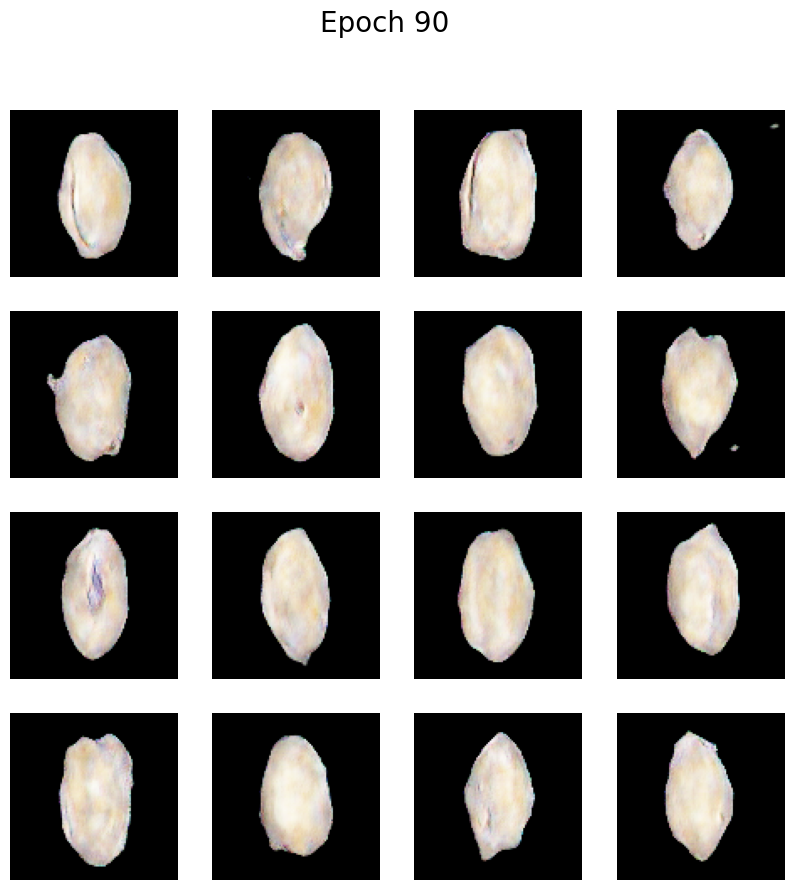

Epoch 91/100, Gen Loss: 5.0630, Disc Loss: 0.1770, Time: 10.35s
Epoch 92/100, Gen Loss: 4.9818, Disc Loss: 0.1674, Time: 9.93s
Epoch 93/100, Gen Loss: 5.1146, Disc Loss: 0.1728, Time: 9.72s
Epoch 94/100, Gen Loss: 4.8876, Disc Loss: 0.1999, Time: 9.71s
Epoch 95/100, Gen Loss: 4.9900, Disc Loss: 0.1721, Time: 9.69s
Epoch 96/100, Gen Loss: 5.3530, Disc Loss: 0.1476, Time: 9.79s
Epoch 97/100, Gen Loss: 4.9907, Disc Loss: 0.1802, Time: 9.70s
Epoch 98/100, Gen Loss: 5.3181, Disc Loss: 0.1512, Time: 9.91s
Epoch 99/100, Gen Loss: 5.4420, Disc Loss: 0.1681, Time: 10.23s
Epoch 100/100, Gen Loss: 5.2795, Disc Loss: 0.1458, Time: 10.07s


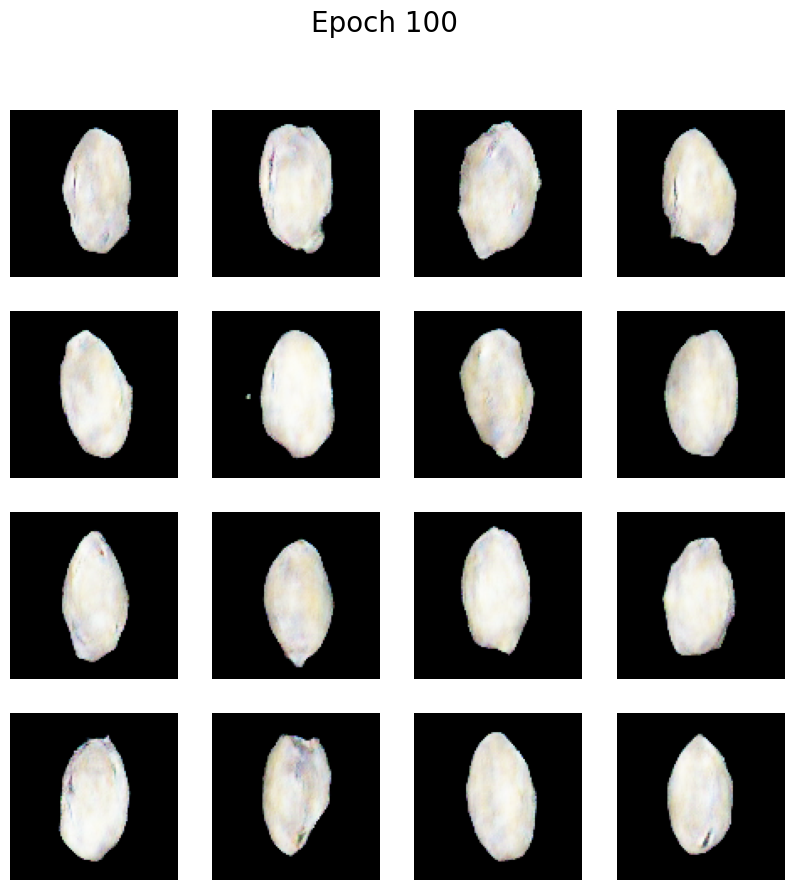

In [10]:
def train(epochs, dataset):
  gen_loss_history = []
  disc_loss_history = []
  
  for epoch in range(epochs):
    start = time.time()
    epoch_gen_loss = 0
    epoch_disc_loss = 0
    num_batches = 0
    
    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      epoch_gen_loss += gen_loss
      epoch_disc_loss += disc_loss
      num_batches += 1
    
    avg_gen_loss = epoch_gen_loss / num_batches
    avg_disc_loss = epoch_disc_loss / num_batches
    
    gen_loss_history.append(avg_gen_loss.numpy())
    disc_loss_history.append(avg_disc_loss.numpy())
    
    print(f'Epoch {epoch+1}/{epochs}, Gen Loss: {avg_gen_loss:.4f}, Disc Loss: {avg_disc_loss:.4f}, Time: {time.time()-start:.2f}s')
    
    if (epoch + 1) % 10 == 0:
      test_noise = tf.random.normal([16, latent_dim])
      generated_images = generator(test_noise, training=False)
      
      plt.figure(figsize=(10, 10))
      for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i] * 0.5 + 0.5)
        plt.axis('off')
      plt.suptitle(f'Epoch {epoch+1}', fontsize=20)
      plt.show()

  return gen_loss_history, disc_loss_history

gen_losses, disc_losses = train(100, dataset)

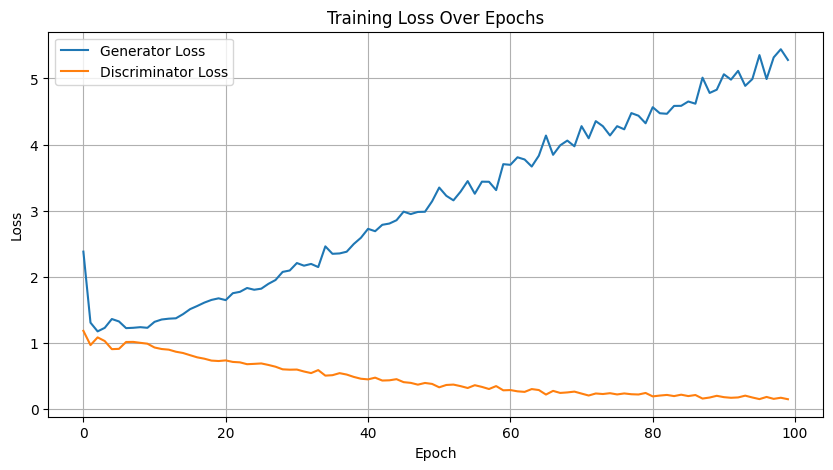

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

- Discriminator loss decreases, indicating the discriminator is getting better at distinguishing real from fake images.
- Generator loss increases, which is expected, as the generator struggles more to fool the increasingly accurate discriminator.

- Although the generator's loss keeps rising, this is still considered a **normal training behavior**. However, it should be monitored to avoid further imbalance.

### Evaluation Baseline

In [21]:
def calculate_fid(real_images, generated_images, batch_size=8):
  inception = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
  
  def preprocess_for_inception(images):
    resized_images = []
    for img in images:
      img = (img + 1) * 127.5  
      img = cv2.resize(img, (299, 299))
      
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      
      img = img.astype(np.float32) / 127.5 - 1.0  
      
      resized_images.append(img)
    return np.array(resized_images)
  
  real_images = preprocess_for_inception(real_images)
  generated_images = preprocess_for_inception(generated_images)
  
  def get_activations(images, model, batch_size=32):
    n_batches = len(images) // batch_size
    act = []
    for i in range(n_batches):
      batch = images[i*batch_size:(i+1)*batch_size]
      act_batch = model.predict(batch)
      act.append(act_batch)
    return np.concatenate(act, axis=0)
  
  act_real = get_activations(real_images, inception, batch_size)
  act_gen = get_activations(generated_images, inception, batch_size)
  
  mu1 = act_real.mean(axis=0)
  mu2 = act_gen.mean(axis=0)
  sigma1 = np.cov(act_real, rowvar=True)
  sigma2 = np.cov(act_gen, rowvar=True)
  
  diff = mu1 - mu2
  covmean = sqrtm(sigma1.dot(sigma2))
  if np.iscomplexobj(covmean):
    covmean = covmean.real
  
  fid = (diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean))
  return fid

In [22]:
def generate_samples(model, n_samples, batch_size=32):
  samples = []
  for _ in range(int(np.ceil(n_samples / batch_size))):
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generated = model.predict(noise, verbose=0) 
    samples.append(generated)
  return np.concatenate(samples, axis=0)[:n_samples]

def prepare_real_samples(real_images, n_samples):
  ix = np.random.randint(0, real_images.shape[0], n_samples)
  return real_images[ix]  

1/1 [==============================] - 0s 32ms/step
FID Score: 89.66


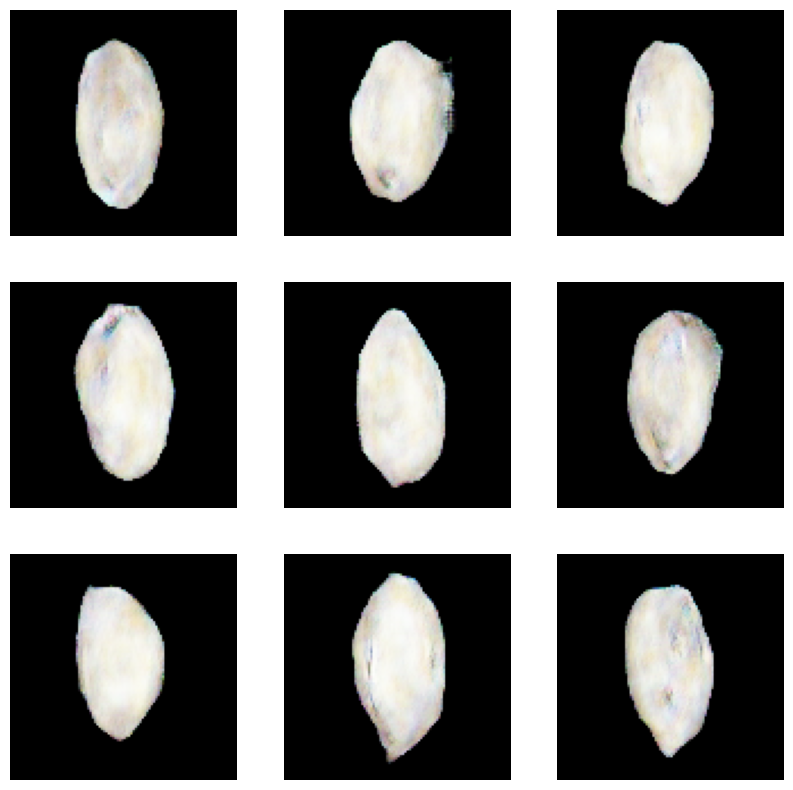

In [23]:
n_samples = min(100, len(_img))
real_images = prepare_real_samples(np.array(_img), n_samples)  
fake_images = generate_samples(generator, n_samples, batch_size=8) 
fid_score = calculate_fid(real_images, fake_images, batch_size=8)

print(f"FID Score: {fid_score:.2f}")

plt.figure(figsize=(10, 10))
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow((fake_images[i] + 1) / 2.0) 
  plt.axis('off')
plt.show()

- The generated images visually resemble pistachio seeds and appear reasonably consistent in shape and structure.
- The FID score is **89.66**, which suggests that while the baseline model can generate plausible images, the quality and diversity could still be improved.
- Overall, the baseline is **acceptable**, but the relatively high FID score indicates there is room for enhancement in generating more realistic and varied samples.

## Modifed Model

In [24]:
def Modified_Generator(latent_dim=100, num_channels=3):
  model = tf.keras.Sequential(name="Generator_Modified")

  model.add(tf.keras.layers.InputLayer(input_shape=(latent_dim,)))
  model.add(tf.keras.layers.Dense(35 * 35 * 64))
  model.add(tf.keras.layers.ReLU())
  model.add(tf.keras.layers.Reshape((35, 35, 64)))

  model.add(tf.keras.layers.UpSampling2D(size=(2, 2)))
  model.add(tf.keras.layers.Conv2D(16, kernel_size=3, strides=1, padding='valid'))
  model.add(tf.keras.layers.ReLU())

  model.add(tf.keras.layers.UpSampling2D(size=(2, 2)))
  model.add(tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='valid'))
  model.add(tf.keras.layers.ReLU())

  model.add(tf.keras.layers.UpSampling2D(size=(2, 2)))
  model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='valid'))
  model.add(tf.keras.layers.ReLU())

  model.add(tf.keras.layers.Conv2D(num_channels, kernel_size=1, strides=1, padding='valid', activation='tanh'))

  model.add(tf.keras.layers.Cropping2D(cropping=((83, 83), (83, 83))))

  return model

m_generator= Modified_Generator()
m_generator.summary()

Model: "Generator_Modified"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 78400)             7918400   
                                                                 
 re_lu (ReLU)                (None, 78400)             0         
                                                                 
 reshape_1 (Reshape)         (None, 35, 35, 64)        0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 70, 70, 64)       0         
 2D)                                                             
                                                                 
 conv2d_383 (Conv2D)         (None, 68, 68, 16)        9232      
                                                                 
 re_lu_1 (ReLU)              (None, 68, 68, 16)        0         
                                                

In [25]:
def Modified_Discriminator(image_shape=(100,100,3)):
  model = Sequential(name="Discriminator_HighCapacity")
    
  model.add(layers.Conv2D(16, (3, 3), strides=1, padding='valid', activation='relu', input_shape= image_shape))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(32, (3, 3), strides=1, padding='valid',  activation='relu'))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(64, (3, 3), strides=1, padding='valid',  activation='relu'))

  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))
  
  return model

m_discriminator= Modified_Discriminator()
m_discriminator.summary()

Model: "Discriminator_HighCapacity"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_387 (Conv2D)         (None, 98, 98, 16)        448       
                                                                 
 dropout (Dropout)           (None, 98, 98, 16)        0         
                                                                 
 conv2d_388 (Conv2D)         (None, 96, 96, 32)        4640      
                                                                 
 dropout_1 (Dropout)         (None, 96, 96, 32)        0         
                                                                 
 conv2d_389 (Conv2D)         (None, 94, 94, 64)        18496     
                                                                 
 flatten_1 (Flatten)         (None, 565504)            0         
                                                                 
 dense_3 (Dense)             (None, 1)  

In [26]:
m_generator_optimizer= tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)
m_discriminator_optimizer= tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)

### Train Modified Model

In [27]:
@tf.function
def m_train_step(images):
  noise = tf.random.normal([batch_size, latent_dim])
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = m_generator(noise, training=True)
    
    real_output = m_discriminator(images, training=True)
    fake_output = m_discriminator(generated_images, training=True)
    
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(fake_output, real_output)
  
  gen_gradients = gen_tape.gradient(gen_loss, m_generator.trainable_variables)
  disc_gradients = disc_tape.gradient(disc_loss, m_discriminator.trainable_variables)
  
  m_generator_optimizer.apply_gradients(zip(gen_gradients, m_generator.trainable_variables))
  m_discriminator_optimizer.apply_gradients(zip(disc_gradients, m_discriminator.trainable_variables))
  
  return gen_loss, disc_loss

In [28]:
def m_train(epochs, dataset):
  gen_loss_history = []
  disc_loss_history = []
  
  for epoch in range(epochs):
    start = time.time()
    total_gen_loss = 0
    total_disc_loss = 0
    num_batches = 0
    
    for image_batch in dataset:
      gen_loss, disc_loss = m_train_step(image_batch)
      total_gen_loss += gen_loss
      total_disc_loss += disc_loss
      num_batches += 1
    
    avg_gen_loss = total_gen_loss / num_batches
    avg_disc_loss = total_disc_loss / num_batches
    
    gen_loss_history.append(avg_gen_loss.numpy())
    disc_loss_history.append(avg_disc_loss.numpy())
    
    if (epoch + 1) % 10 == 0:
      test_noise = tf.random.normal([16, latent_dim])
      generated_images = m_generator(test_noise, training=False)
      
      plt.figure(figsize=(10, 10))
      for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i] * 0.5 + 0.5)
        plt.axis('off')
      plt.show()
    
    print(f'Epoch {epoch+1}/{epochs} | '
          f'Generator Loss: {avg_gen_loss:.4f} | '
          f'Discriminator Loss: {avg_disc_loss:.4f} | '
          f'Time: {time.time()-start:.2f}s')
  
  return gen_loss_history, disc_loss_history

Epoch 1/100 | Generator Loss: 1.8527 | Discriminator Loss: 1.1312 | Time: 18.97s
Epoch 2/100 | Generator Loss: 1.0480 | Discriminator Loss: 1.2152 | Time: 16.49s
Epoch 3/100 | Generator Loss: 1.0343 | Discriminator Loss: 1.1910 | Time: 16.36s
Epoch 4/100 | Generator Loss: 0.9452 | Discriminator Loss: 1.2490 | Time: 16.25s
Epoch 5/100 | Generator Loss: 0.9157 | Discriminator Loss: 1.2341 | Time: 16.23s
Epoch 6/100 | Generator Loss: 0.9608 | Discriminator Loss: 1.1651 | Time: 16.17s
Epoch 7/100 | Generator Loss: 1.0153 | Discriminator Loss: 1.1202 | Time: 16.61s
Epoch 8/100 | Generator Loss: 1.0587 | Discriminator Loss: 1.0715 | Time: 16.77s
Epoch 9/100 | Generator Loss: 1.1030 | Discriminator Loss: 1.0645 | Time: 14.44s


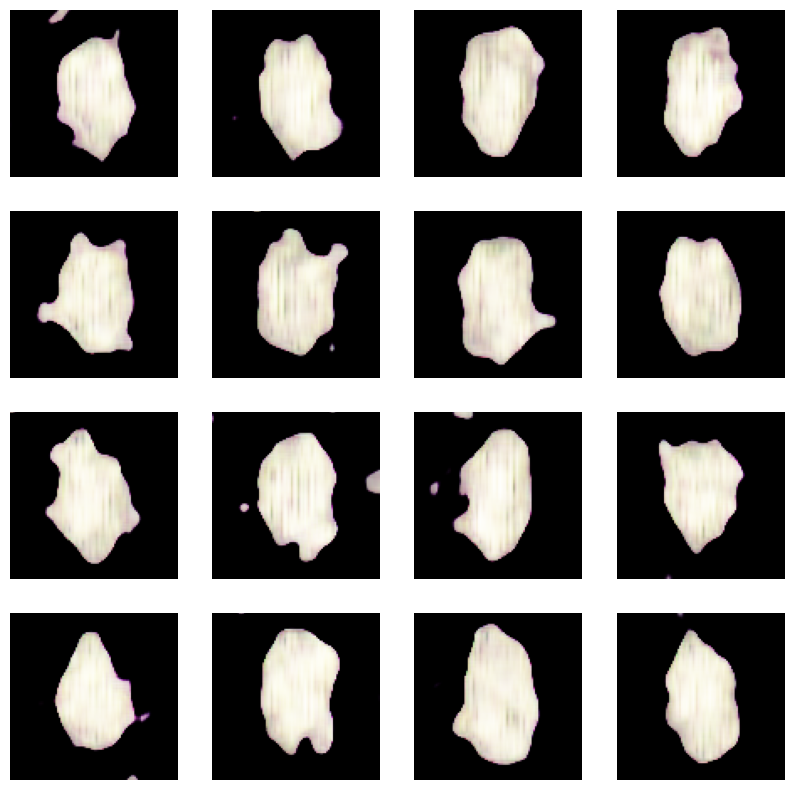

Epoch 10/100 | Generator Loss: 1.0702 | Discriminator Loss: 1.1070 | Time: 15.56s
Epoch 11/100 | Generator Loss: 1.2337 | Discriminator Loss: 1.0034 | Time: 15.87s
Epoch 12/100 | Generator Loss: 1.1643 | Discriminator Loss: 0.9964 | Time: 15.56s
Epoch 13/100 | Generator Loss: 1.3134 | Discriminator Loss: 0.9317 | Time: 16.04s
Epoch 14/100 | Generator Loss: 1.4647 | Discriminator Loss: 0.8465 | Time: 97.14s
Epoch 15/100 | Generator Loss: 1.4740 | Discriminator Loss: 0.8601 | Time: 22.64s
Epoch 16/100 | Generator Loss: 1.5207 | Discriminator Loss: 0.8096 | Time: 15.93s
Epoch 17/100 | Generator Loss: 1.4231 | Discriminator Loss: 0.8989 | Time: 16.05s
Epoch 18/100 | Generator Loss: 1.4171 | Discriminator Loss: 0.8965 | Time: 16.10s
Epoch 19/100 | Generator Loss: 1.3684 | Discriminator Loss: 0.9238 | Time: 16.12s


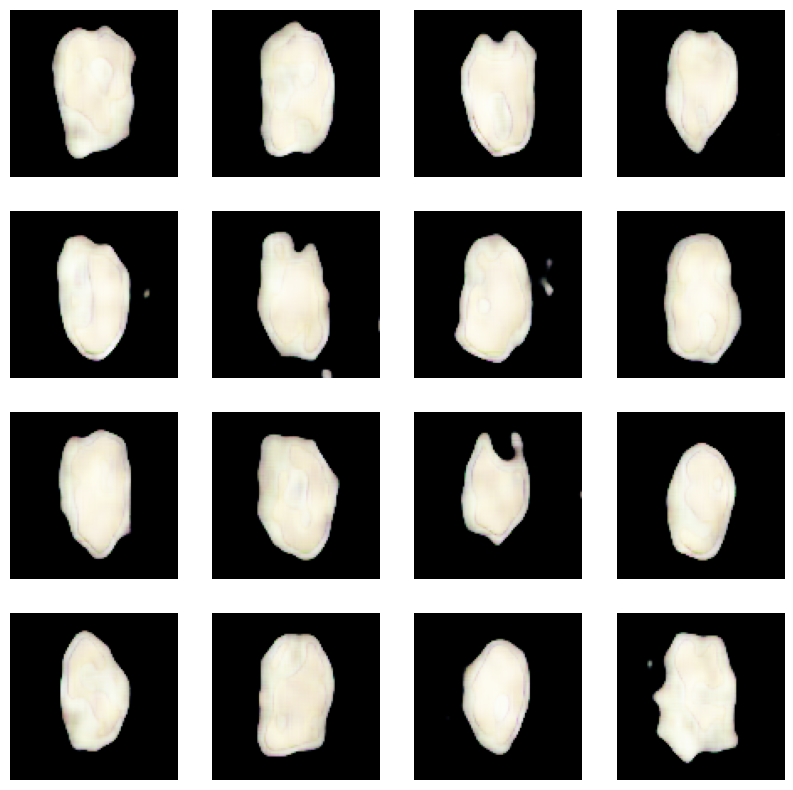

Epoch 20/100 | Generator Loss: 1.3951 | Discriminator Loss: 0.9318 | Time: 16.62s
Epoch 21/100 | Generator Loss: 1.4258 | Discriminator Loss: 0.9275 | Time: 16.16s
Epoch 22/100 | Generator Loss: 1.4400 | Discriminator Loss: 0.8973 | Time: 15.71s
Epoch 23/100 | Generator Loss: 1.4897 | Discriminator Loss: 0.8901 | Time: 15.73s
Epoch 24/100 | Generator Loss: 1.3697 | Discriminator Loss: 0.9599 | Time: 15.72s
Epoch 25/100 | Generator Loss: 1.5365 | Discriminator Loss: 0.8530 | Time: 15.71s
Epoch 26/100 | Generator Loss: 1.4507 | Discriminator Loss: 0.9224 | Time: 15.70s
Epoch 27/100 | Generator Loss: 1.5091 | Discriminator Loss: 0.8627 | Time: 15.71s
Epoch 28/100 | Generator Loss: 1.5768 | Discriminator Loss: 0.8195 | Time: 15.77s
Epoch 29/100 | Generator Loss: 1.6292 | Discriminator Loss: 0.8105 | Time: 15.85s


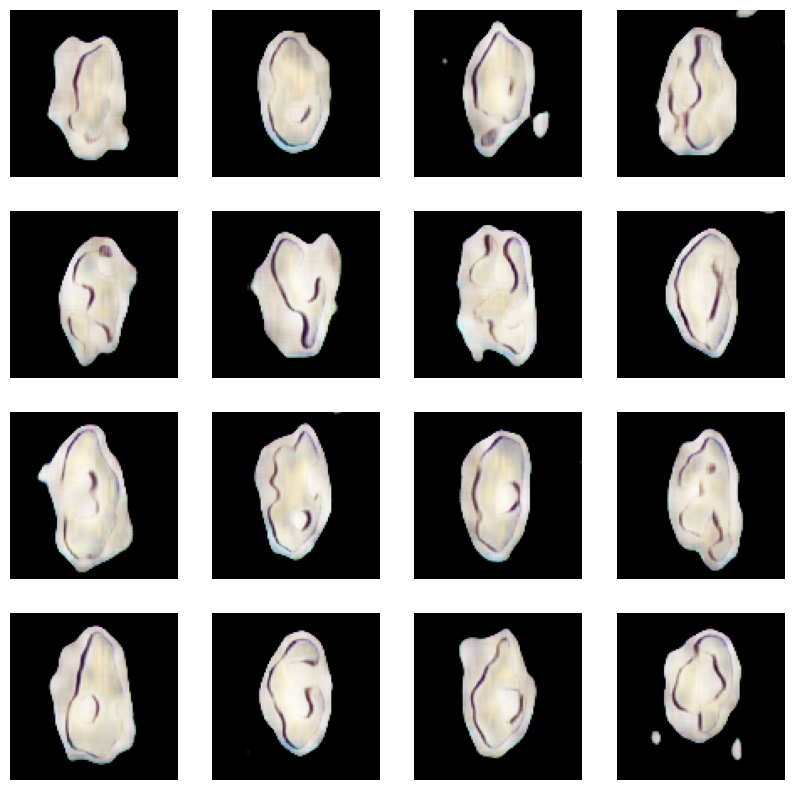

Epoch 30/100 | Generator Loss: 1.6611 | Discriminator Loss: 0.7950 | Time: 16.03s
Epoch 31/100 | Generator Loss: 1.8485 | Discriminator Loss: 0.7388 | Time: 15.70s
Epoch 32/100 | Generator Loss: 1.6843 | Discriminator Loss: 0.8116 | Time: 15.75s
Epoch 33/100 | Generator Loss: 1.7173 | Discriminator Loss: 0.7845 | Time: 16.15s
Epoch 34/100 | Generator Loss: 1.6611 | Discriminator Loss: 0.7653 | Time: 16.68s
Epoch 35/100 | Generator Loss: 1.8150 | Discriminator Loss: 0.7508 | Time: 16.77s
Epoch 36/100 | Generator Loss: 1.7258 | Discriminator Loss: 0.7734 | Time: 16.55s
Epoch 37/100 | Generator Loss: 1.8584 | Discriminator Loss: 0.7212 | Time: 16.76s
Epoch 38/100 | Generator Loss: 1.7921 | Discriminator Loss: 0.7742 | Time: 16.24s
Epoch 39/100 | Generator Loss: 1.8995 | Discriminator Loss: 0.7364 | Time: 16.19s


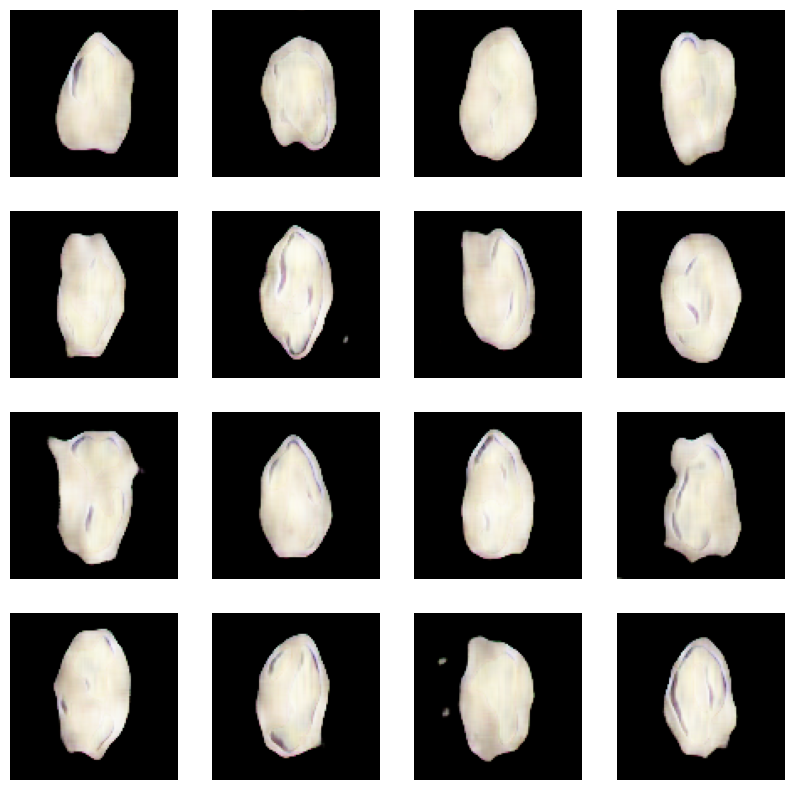

Epoch 40/100 | Generator Loss: 1.8422 | Discriminator Loss: 0.7317 | Time: 16.53s
Epoch 41/100 | Generator Loss: 1.9465 | Discriminator Loss: 0.7089 | Time: 16.52s
Epoch 42/100 | Generator Loss: 2.0458 | Discriminator Loss: 0.6856 | Time: 16.19s
Epoch 43/100 | Generator Loss: 2.0366 | Discriminator Loss: 0.6783 | Time: 16.26s
Epoch 44/100 | Generator Loss: 2.0785 | Discriminator Loss: 0.6831 | Time: 16.24s
Epoch 45/100 | Generator Loss: 1.9436 | Discriminator Loss: 0.6992 | Time: 16.25s
Epoch 46/100 | Generator Loss: 2.1505 | Discriminator Loss: 0.6708 | Time: 16.26s
Epoch 47/100 | Generator Loss: 2.0561 | Discriminator Loss: 0.7100 | Time: 16.28s
Epoch 48/100 | Generator Loss: 2.1456 | Discriminator Loss: 0.6394 | Time: 16.28s
Epoch 49/100 | Generator Loss: 2.2394 | Discriminator Loss: 0.6205 | Time: 16.48s


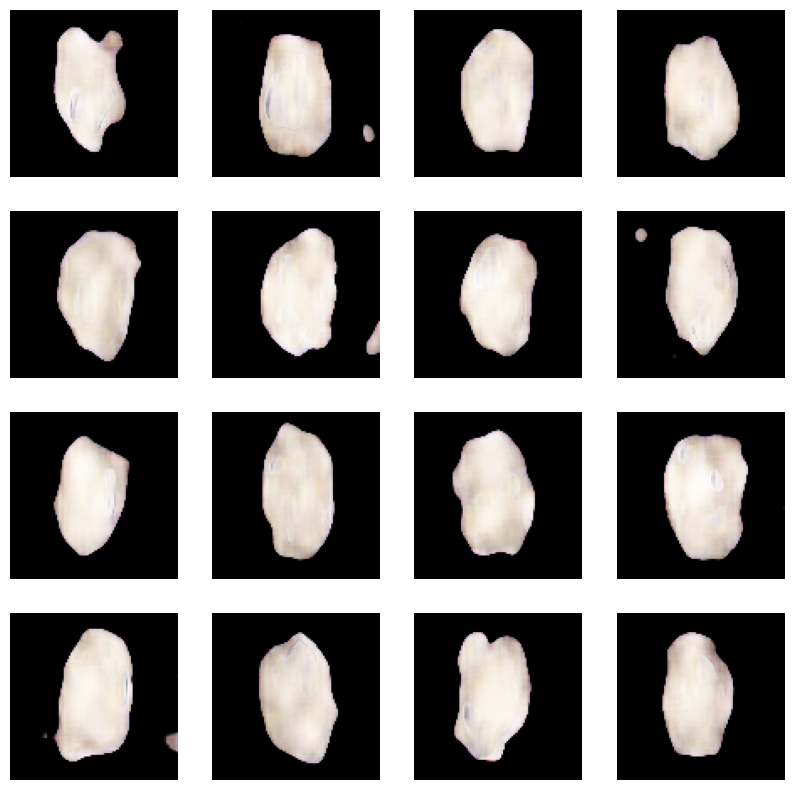

Epoch 50/100 | Generator Loss: 2.3737 | Discriminator Loss: 0.5822 | Time: 16.05s
Epoch 51/100 | Generator Loss: 2.4584 | Discriminator Loss: 0.5783 | Time: 16.77s
Epoch 52/100 | Generator Loss: 2.3053 | Discriminator Loss: 0.5895 | Time: 16.75s
Epoch 53/100 | Generator Loss: 2.2764 | Discriminator Loss: 0.6203 | Time: 15.69s
Epoch 54/100 | Generator Loss: 2.4474 | Discriminator Loss: 0.5724 | Time: 124.87s
Epoch 55/100 | Generator Loss: 2.4151 | Discriminator Loss: 0.5834 | Time: 16.50s
Epoch 56/100 | Generator Loss: 2.4824 | Discriminator Loss: 0.5710 | Time: 16.10s
Epoch 57/100 | Generator Loss: 2.4132 | Discriminator Loss: 0.5772 | Time: 16.14s
Epoch 58/100 | Generator Loss: 2.4394 | Discriminator Loss: 0.5778 | Time: 16.16s
Epoch 59/100 | Generator Loss: 2.5758 | Discriminator Loss: 0.5300 | Time: 16.40s


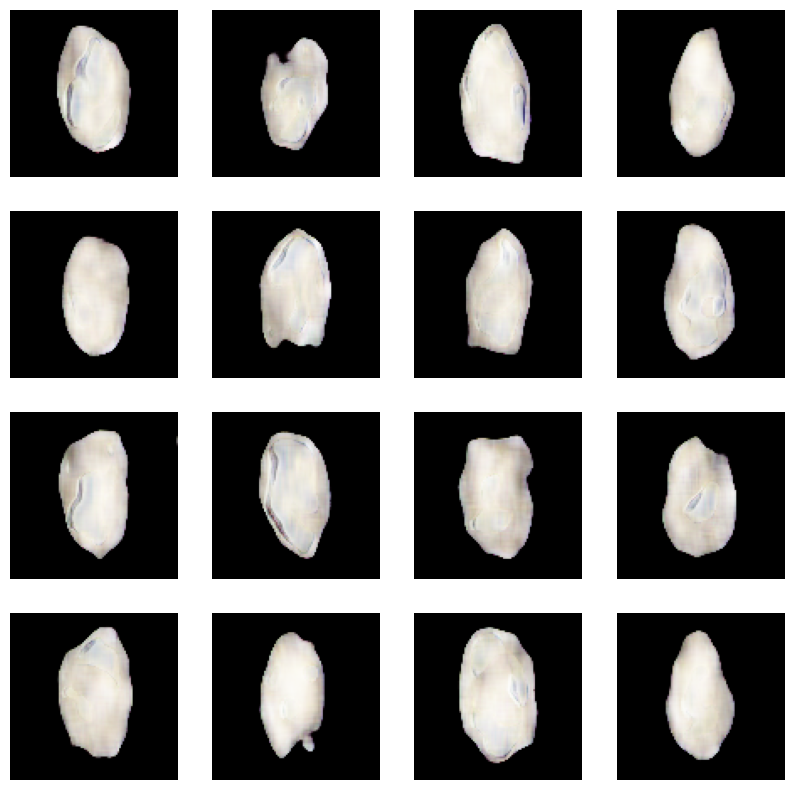

Epoch 60/100 | Generator Loss: 2.6882 | Discriminator Loss: 0.5061 | Time: 17.03s
Epoch 61/100 | Generator Loss: 2.6052 | Discriminator Loss: 0.5445 | Time: 16.67s
Epoch 62/100 | Generator Loss: 2.7755 | Discriminator Loss: 0.5014 | Time: 16.38s
Epoch 63/100 | Generator Loss: 2.5837 | Discriminator Loss: 0.5379 | Time: 16.38s
Epoch 64/100 | Generator Loss: 2.7318 | Discriminator Loss: 0.4908 | Time: 16.11s
Epoch 65/100 | Generator Loss: 2.8540 | Discriminator Loss: 0.4631 | Time: 15.81s
Epoch 66/100 | Generator Loss: 2.8005 | Discriminator Loss: 0.5055 | Time: 15.77s
Epoch 67/100 | Generator Loss: 3.0094 | Discriminator Loss: 0.4479 | Time: 15.69s
Epoch 68/100 | Generator Loss: 3.0358 | Discriminator Loss: 0.4785 | Time: 15.65s
Epoch 69/100 | Generator Loss: 2.8186 | Discriminator Loss: 0.4888 | Time: 15.65s


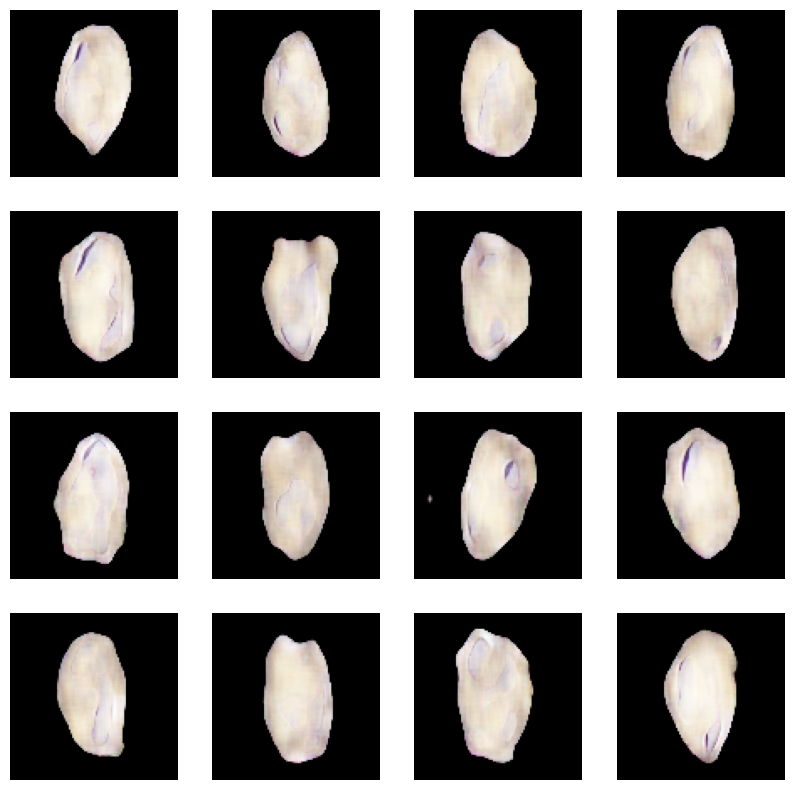

Epoch 70/100 | Generator Loss: 2.9705 | Discriminator Loss: 0.4772 | Time: 16.05s
Epoch 71/100 | Generator Loss: 3.0370 | Discriminator Loss: 0.4941 | Time: 15.63s
Epoch 72/100 | Generator Loss: 2.9920 | Discriminator Loss: 0.4501 | Time: 15.61s
Epoch 73/100 | Generator Loss: 2.9921 | Discriminator Loss: 0.4723 | Time: 15.60s
Epoch 74/100 | Generator Loss: 3.2330 | Discriminator Loss: 0.4023 | Time: 15.61s
Epoch 75/100 | Generator Loss: 3.1132 | Discriminator Loss: 0.4500 | Time: 15.60s
Epoch 76/100 | Generator Loss: 3.1091 | Discriminator Loss: 0.4612 | Time: 15.58s
Epoch 77/100 | Generator Loss: 3.1796 | Discriminator Loss: 0.4394 | Time: 15.60s
Epoch 78/100 | Generator Loss: 3.3782 | Discriminator Loss: 0.3873 | Time: 15.58s
Epoch 79/100 | Generator Loss: 3.1525 | Discriminator Loss: 0.4500 | Time: 15.59s


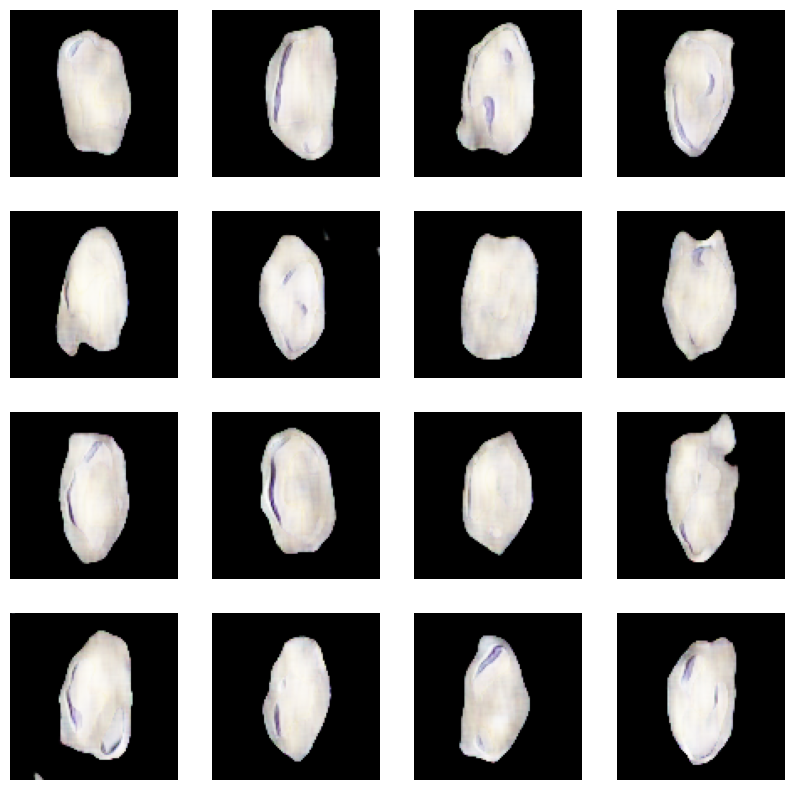

Epoch 80/100 | Generator Loss: 3.2118 | Discriminator Loss: 0.4209 | Time: 16.66s
Epoch 81/100 | Generator Loss: 3.2168 | Discriminator Loss: 0.4294 | Time: 16.24s
Epoch 82/100 | Generator Loss: 3.5441 | Discriminator Loss: 0.3532 | Time: 80.03s
Epoch 83/100 | Generator Loss: 3.4498 | Discriminator Loss: 0.3822 | Time: 40.90s
Epoch 84/100 | Generator Loss: 3.3732 | Discriminator Loss: 0.4273 | Time: 13.69s
Epoch 85/100 | Generator Loss: 3.3806 | Discriminator Loss: 0.3705 | Time: 13.71s
Epoch 86/100 | Generator Loss: 3.2556 | Discriminator Loss: 0.4081 | Time: 13.70s
Epoch 87/100 | Generator Loss: 3.5551 | Discriminator Loss: 0.3261 | Time: 13.70s
Epoch 88/100 | Generator Loss: 3.4426 | Discriminator Loss: 0.4160 | Time: 37.37s
Epoch 89/100 | Generator Loss: 3.4573 | Discriminator Loss: 0.3704 | Time: 13.74s


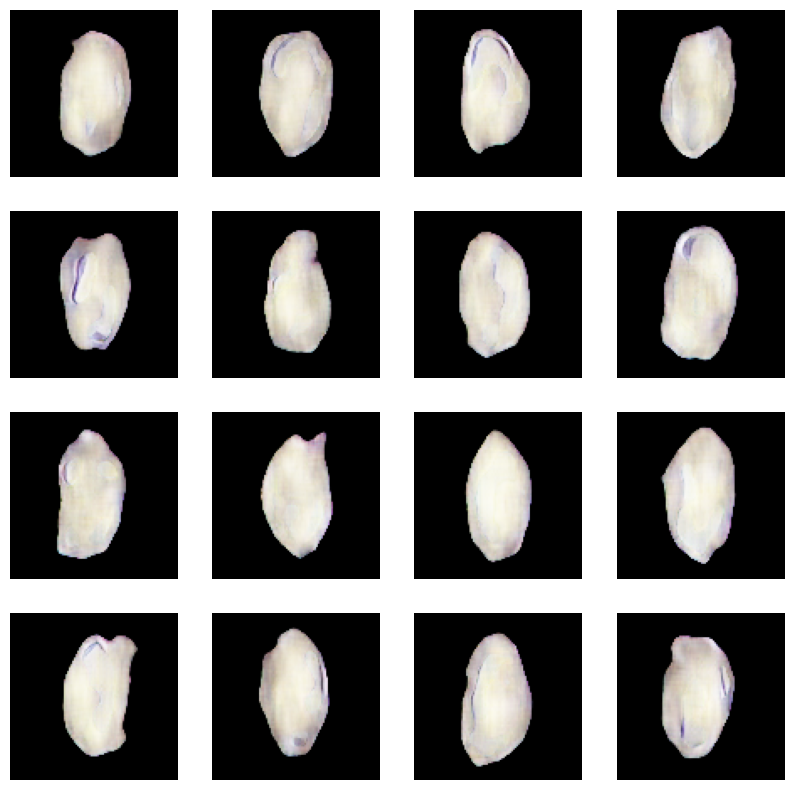

Epoch 90/100 | Generator Loss: 3.3755 | Discriminator Loss: 0.4417 | Time: 14.66s
Epoch 91/100 | Generator Loss: 3.6595 | Discriminator Loss: 0.3171 | Time: 14.07s
Epoch 92/100 | Generator Loss: 3.6900 | Discriminator Loss: 0.3764 | Time: 14.65s
Epoch 93/100 | Generator Loss: 3.6801 | Discriminator Loss: 0.3147 | Time: 14.70s
Epoch 94/100 | Generator Loss: 3.5654 | Discriminator Loss: 0.3596 | Time: 14.96s
Epoch 95/100 | Generator Loss: 3.5292 | Discriminator Loss: 0.3949 | Time: 14.80s
Epoch 96/100 | Generator Loss: 3.4639 | Discriminator Loss: 0.3796 | Time: 14.86s
Epoch 97/100 | Generator Loss: 3.8505 | Discriminator Loss: 0.3094 | Time: 15.03s
Epoch 98/100 | Generator Loss: 3.7580 | Discriminator Loss: 0.3792 | Time: 15.30s
Epoch 99/100 | Generator Loss: 3.7146 | Discriminator Loss: 0.3676 | Time: 15.11s


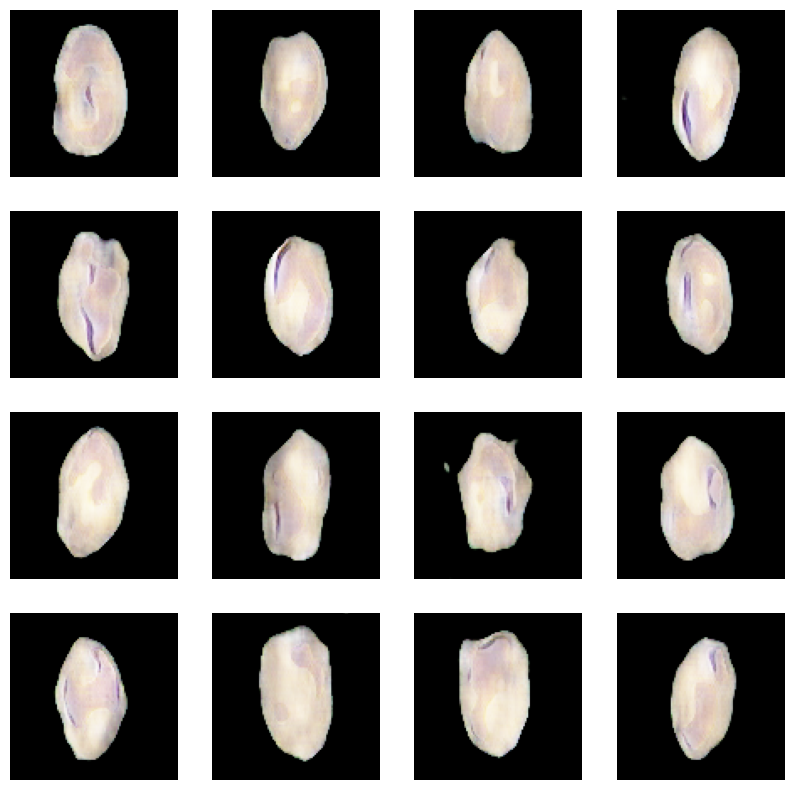

Epoch 100/100 | Generator Loss: 3.7406 | Discriminator Loss: 0.3413 | Time: 15.67s


In [29]:
EPOCHS= 100

gen_losses, disc_losses= m_train(EPOCHS, dataset)

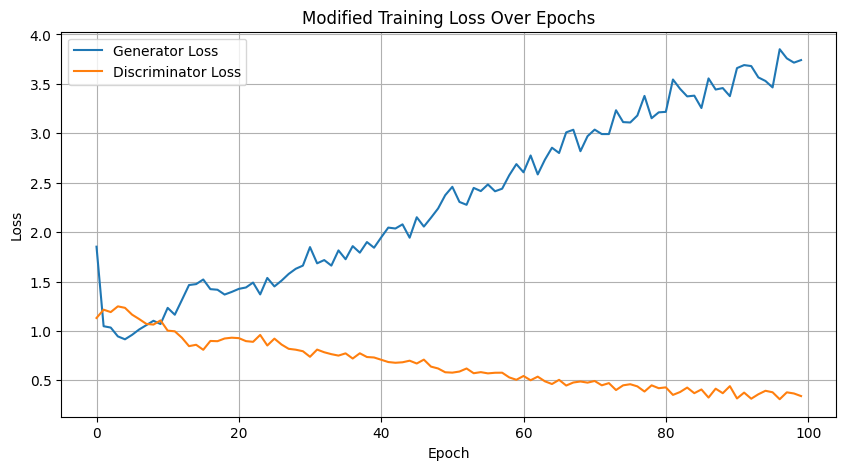

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')
plt.title('Modified Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

- The generator loss shows a consistent upward trend, which is expected as the discriminator improves.
- The discriminator loss decreases steadily, indicating it's learning to distinguish between real and generated images more effectively.
- The pattern looks normal and **training is proceeding as expected**, without instability.

### Evaluation Modified Model

In [32]:
m_fake_images = generate_samples(m_generator, n_samples,  batch_size=8)
m_fid_score = calculate_fid(real_images, m_fake_images, batch_size=8)
print(f"Modified FID Score: {m_fid_score:.2f}")

1/1 [==============================] - 0s 53ms/step
Modified FID Score: 78.52


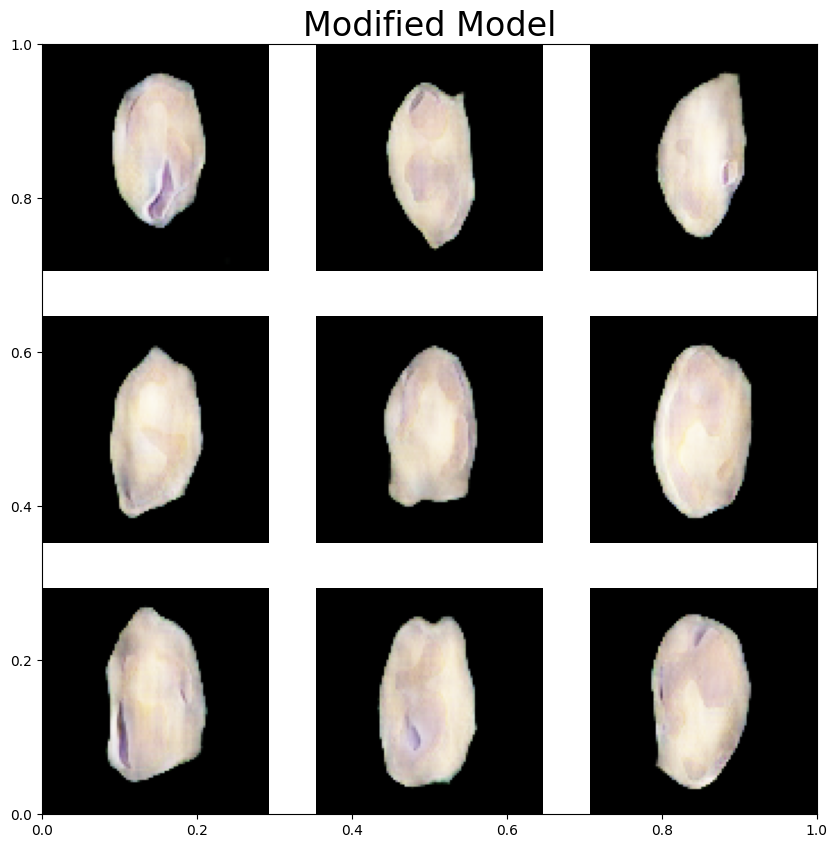

In [38]:
plt.figure(figsize=(10, 10))
plt.title("Modified Model", fontsize=24)
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow((m_fake_images[i] + 1) / 2.0) 
  plt.axis('off')
plt.show()

## Final Evaluation Summary

In [35]:
print("\n===== Final Result =====")
print(f"Baseline FID: {fid_score:.2f}")
print(f"Modified FID: {m_fid_score:.2f}")
print(f"Improvement: {fid_score - m_fid_score:.2f}")


===== Final Result =====
Baseline FID: 89.66
Modified FID: 78.52
Improvement: 11.14


- The modified model shows a **notable improvement** in FID score, indicating that the generated images are more similar to the real ones compared to the baseline.

- While an FID of 78.52 is **better** than the baseline, it's still considered **moderate** in terms of image quality. Generally, an FID score **below 50** is considered good, and **below 20** is excellent. So, although this result reflects progress, there’s **room for further enhancement** in generation quality.